# CS-6600 Assignment 8 - Support Vector Machine Classification

**Belal Glab**

*Weber State University*

For this assignment, we're going to use a support vector classifier to build a model for predicting whether a car will have high or low gas mileage.

First, let's import the libraries we'll want to use:

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn as skl
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay


from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

In [41]:
roc_curve = RocCurveDisplay.from_estimator

Next, let's define some functions (from the support vector machine lecture notes) that we'll use for drawing decision boundaries.

First, for support vector classifiers with linear kernels:

In [3]:

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

Next for support vector machine with nonlinear kernels:

In [4]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

###Support Vector Classifier Review

To review the basics of support vector classifiers, let's create some data that we'll try to classify:

In [5]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50,2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1

Let's plot this data, differentiating between the two classes with both colors and shapes:

(-3.0, 3.0, -3.0, 3.0)

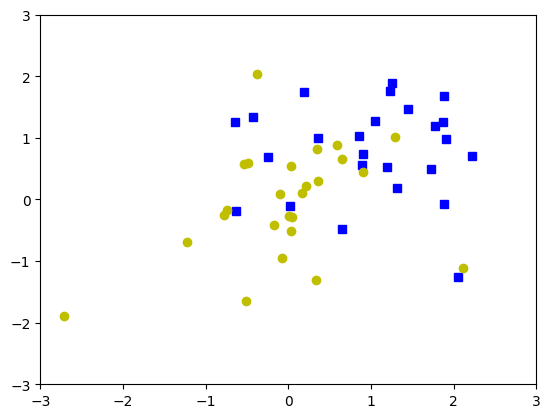

In [6]:
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "yo")
plt.axis([-3, 3, -3, 3])

Let's try to separate this data with a support vector classifier using a linear kernel and with a $C$ value of 10:

In [7]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X,y)

SVC(C=10, kernel='linear')

If we plot this classifier, its margin, and the support vectors we get:

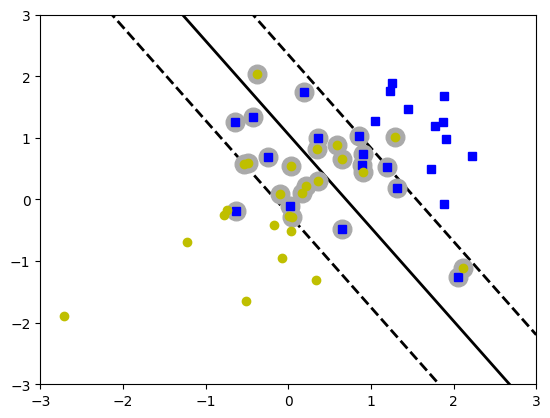

In [8]:
plot_svc_decision_boundary(svm_linear, -3, 3)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "yo")
plt.axis([-3, 3, -3, 3])
plt.show()

Now, suppose we relax our $C$ value penalty term a bit, allowing more misclassifications. Our new SVM classifier is:

In [9]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)

SVC(C=0.1, kernel='linear')

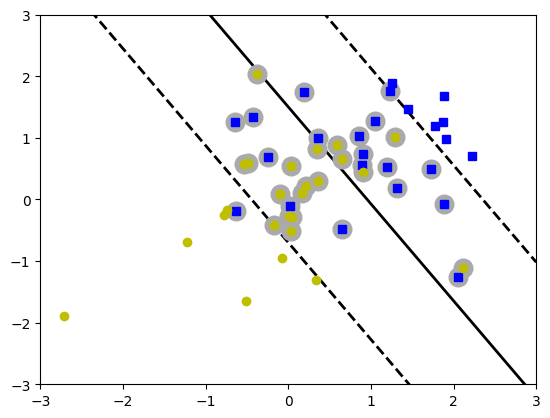

In [10]:
plot_svc_decision_boundary(svm_linear_small, -3, 3)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "yo")
plt.axis([-3, 3, -3, 3])
plt.show()

Which one should we use? Well, $C$ is a hyperparameter, and so the way we usually determine an ideal hyperparameters is through cross-validation. We can use 5-fold crass validation and grid search to find the best value for $C$ (measured in terms of classification accuraty).

In [11]:
kfold = skl.model_selection.KFold(5, random_state=6600, shuffle = True)
grid = skl.model_selection.GridSearchCV(svm_linear, {'C':[0.001,0.01, 0.1, 1, 5, 10, 100]}, refit = True, cv=kfold, scoring='accuracy')
grid.fit(X,y)
grid.best_params_

{'C': 0.1}

To see how this model with $C = 0.1$ does on our data, we can check out the confusion matrix for its predictions:

In [12]:
best = grid.best_estimator_
y_hat = best.predict(X)

In [13]:
confusion_matrix(y, y_hat)

array([[20,  5],
       [ 6, 19]])

Looks like it correctly classifier $39$ out of $50$ data points. Not bad!

###Support Vector Machine Review

The boundaries of a support vector classifier don't always have to be linear. In fact, when we allow them to be non-linear, that's when we get our more  general "support vector machines".

Let's check this out for some data that's definitely not linearly separable.

In [14]:
X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

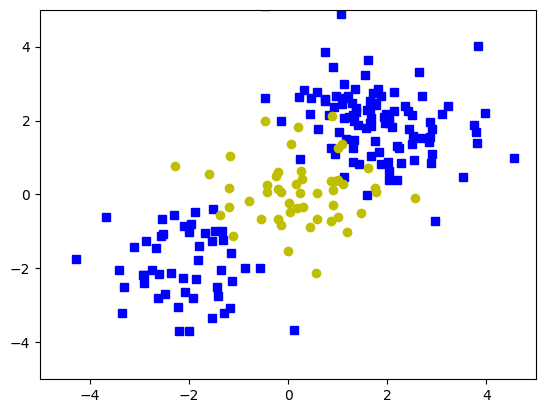

In [15]:
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "yo")
plt.axis([-5, 5, -5, 5])
plt.show()

Let's split this up into training and test data:

In [16]:
(X_train,X_test,y_train,y_test) = train_test_split(X,y,test_size=0.5,random_state=6600)

Let's fit a third-degree polynomial kernal to the training data:

In [17]:
svm_poly = SVC(kernel="poly", degree=3, coef0 = 1, C=5)
svm_poly.fit(X_train , y_train)

SVC(C=5, coef0=1, kernel='poly')

The classification boundary we get looks like:

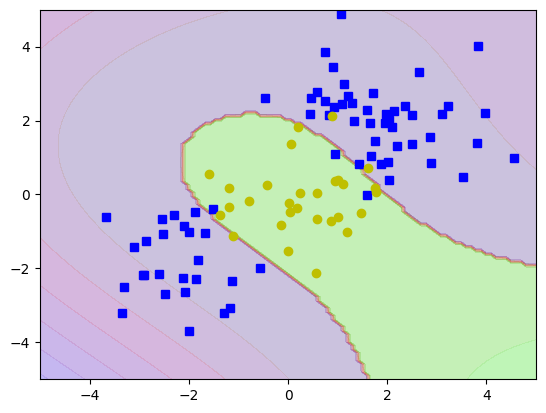

In [18]:
plot_predictions(svm_poly, [-5, 5, -5, 5])
plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs")
plt.plot(X_train[:, 0][y_train==2], X_train[:, 1][y_train==2], "yo")
plt.axis([-5, 5, -5, 5])
plt.show()

For the test data it looks like:

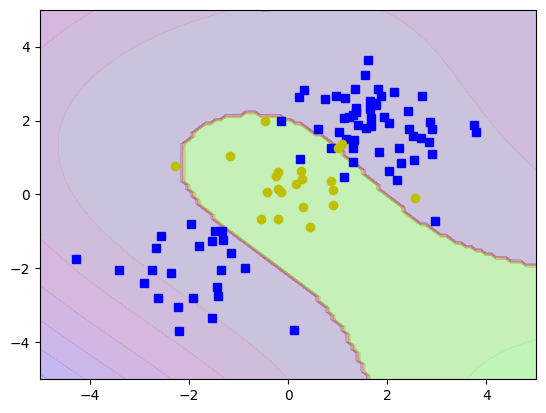

In [19]:
plot_predictions(svm_poly, [-5, 5, -5, 5])
plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], "bs")
plt.plot(X_test[:, 0][y_test==2], X_test[:, 1][y_test==2], "yo")
plt.axis([-5, 5, -5, 5])
plt.show()

Decent fit. But what's the best combination of degree and penalty $C$?

Well, we can use a grid search to try to find them:

In [20]:
kfold = skl.model_selection.KFold(5,random_state=6600,shuffle=True)
grid = skl.model_selection.GridSearchCV(svm_poly ,
{'C':[0.1,1,10,100,1000],'degree':[1,2,3,4,5]},
refit=True,cv=kfold,
scoring='accuracy');
grid.fit(X_train , y_train)
grid.best_params_

{'C': 0.1, 'degree': 3}

Looks like degree 3 was the way to go, although with a slightly smaller penalty. Let's see what it looks like on the test data:

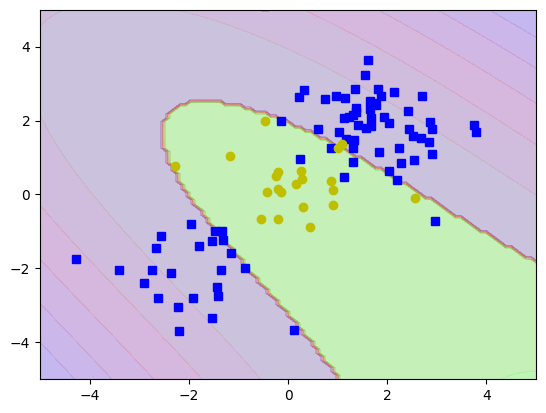

In [21]:
best_svm = grid.best_estimator_
plot_predictions(best_svm, [-5, 5, -5, 5])
plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], "bs")
plt.plot(X_test[:, 0][y_test==2], X_test[:, 1][y_test==2], "yo")
plt.axis([-5, 5, -5, 5])
plt.show()

Not bad at all. The confusion matrix for the test data is:

In [22]:
y_hat = best_svm.predict(X_test)
confusion_matrix(y_test, y_hat)

array([[71,  8],
       [ 1, 20]])

Pretty, pretty good. We can also check out the ROC curve and the AUC:

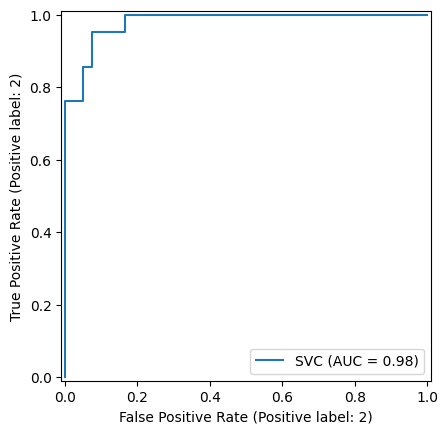

In [23]:
roc_curve(best_svm, X_test, y_test)
plt.show()

##Predicting Efficient Cars

For your part of the assignment, youll be trying to build a model to predict which cars are efficient (in terms of their mpg). To do this, we'll use the "auto" dataset, which consists of 392 observations on the following 9 variables:

* mpg: miles per gallon

* cylinders: Number of cylinders between 4 and 8

* displacement: Engine displacement (cu. inches)

* horsepower: Engine horsepower

* weight: Vehicle weight (lbs.)

* acceleration: Time to accelerate from 0 to 60 mph (sec.)

* year: Model year (modulo 100)

* origin: Origin of car (1. American, 2. European, 3. Japanese)

* name: Vehicle name

In [25]:
#Import the Auto data
url = 'https://drive.google.com/uc?export=download&id=1jSwnvnwQuJel1Wc4junE8QR3IIv7Gm45'
auto = pd.read_csv(url)
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,9.0,8,304.0,193,4732,18.5,70,1,hi 1200d
1,10.0,8,307.0,200,4376,15.0,70,1,chevy c20
2,10.0,8,360.0,215,4615,14.0,70,1,ford f250
3,11.0,8,400.0,150,4997,14.0,73,1,chevrolet impala
4,11.0,8,318.0,210,4382,13.5,70,1,dodge d200
...,...,...,...,...,...,...,...,...,...
387,43.4,4,90.0,48,2335,23.7,80,2,vw dasher (diesel)
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,44.3,4,90.0,48,2085,21.7,80,2,vw rabbit c (diesel)
390,44.6,4,91.0,67,1850,13.8,80,3,honda civic 1500 gl


In [26]:
auto.shape

(392, 9)

In [27]:
auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

Create a binary variable that takes on a 1 for cars with gas mileage above the median, and a 0 for cars with gas mileage below the median.

In [28]:
#YOUR CODE HERE

auto['mpg_above_median'] = (auto['mpg'] > auto['mpg'].median()).astype(int)


 Fit a support vector classifier to the data in order to predict whether a car gets high or low gas mileage. Use grid search to determine a good value of $C$ for the model.

 *Note* - You will, of course, need to fit the classifier without the miles per gallon variable. Otherwise, it would be way too easy.

In [33]:
#YOUR CODE HERE
# Drop 'mpg' and 'name' columns
X = auto.drop(['mpg', 'name', 'mpg_above_median'], axis=1)
y = auto['mpg_above_median']

# Spliting  data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a support vector classifier
svm_clf = SVC(kernel='linear')

# Use GridSearchCV to find the best value of C
param_grid = {'C': [0.1, 1, 10, 100]}
grid_search = skl.model_selection.GridSearchCV(svm_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best C value found by GridSearchCV
print("Best C:", grid_search.best_params_['C'])

# Train the model with the best C value
best_svm_clf = SVC(kernel='linear', C=grid_search.best_params_['C'])
best_svm_clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_svm_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Best C: 0.1
Confusion Matrix:
 [[53  4]
 [ 1 40]]


For the value of $C$ you found with grid search, construct the ROC curve and report the AUC.

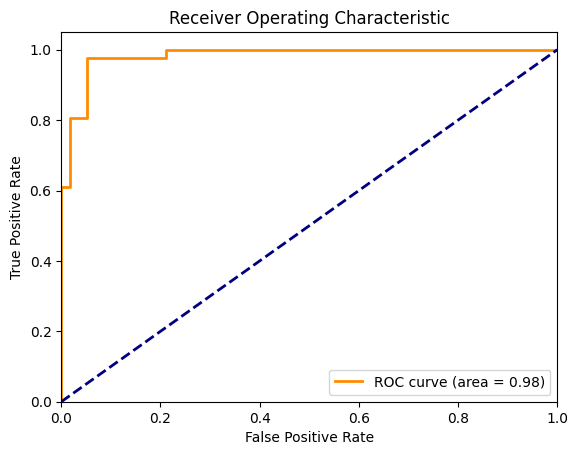

AUC: 0.9824561403508771


In [37]:
#YOUR CODE HERE
y_score = best_svm_clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)



Repeat the analysis above, but now using an SVM with a polynomial basis kernel, and use grid search to find an optimal value for the degree, as well as $C$.

Best parameters: {'C': 100, 'degree': 2}
Confusion Matrix:
 [[50  7]
 [ 1 40]]
Accuracy: 0.9183673469387755


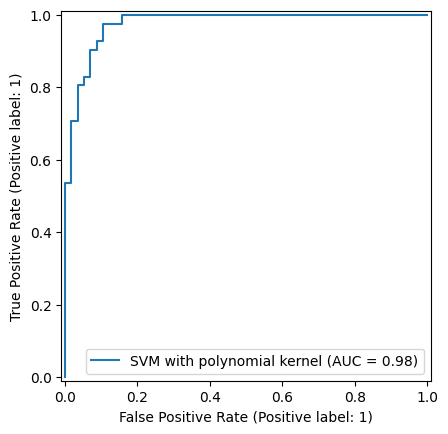

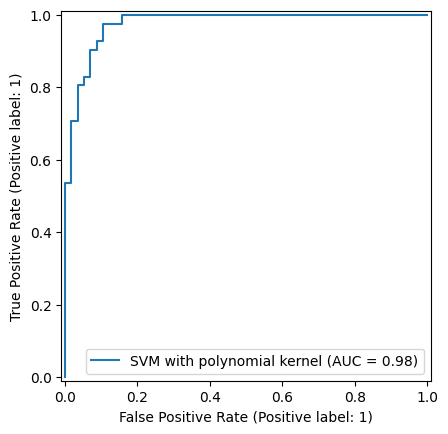

In [45]:
#YOUR CODE HERE
# I will use the vector classifier with a polynomial kernel
svm_poly = SVC(kernel="poly", coef0=1)

# Define the parameter grid for grid search
param_grid = {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4]}

# Perform grid search with 5-fold cross-validation
grid_search = skl.model_selection.GridSearchCV(svm_poly, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters:", grid_search.best_params_)

# Train the model with the best parameters
best_svm_poly = grid_search.best_estimator_
best_svm_poly.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_svm_poly.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Calculate and print the accuracy
accuracy = skl.metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Get the decision function scores for the test set
y_score = best_svm_poly.decision_function(X_test)

# Here, I will use form the predections
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='SVM with polynomial kernel')

# from sklearn.metrics import RocCurveDisplay
display = RocCurveDisplay.from_predictions(y_test, y_score,name='SVM with polynomial kernel')

display.plot()
plt.show()

When you're done, please upload your Jupyter Notebook to Canvas.

DON'T FORGET TO PUT YOUR NAME AT THE TOP!